# Geospatial Crop Targeting System for Cambodia
## Data Science Workflow: Soil-Based Agricultural Zoning

**Project:** National Soil Information and Land Suitability Evaluation System  
**Objective:** Develop an evidence-based system for agricultural zone classification using geospatial data and machine learning.

---

## Workflow Overview

| Phase | Cell | Method |
|-------|------|--------|
| **1. Problem Definition** | Intro | Business objectives & success metrics |
| **2. Data Acquisition** | 1-2 | Load shapefile & production data |
| **3. EDA** | 3-4 | Statistical summaries & distributions |
| **4. Data Cleaning** | 5 | Handle missing values & CRS alignment |
| **5. Feature Engineering** | 6-7 | Rule-based classification & preprocessing |
| **6. Visualization** | 8-9 | Distributions, correlations, heatmaps |
| **7. ML Implementation** | 10-11 | K-Means clustering & model evaluation |
| **8. Model Interpretation** | 12 | Cluster characterization & insights |
| **9. Advanced Visualization** | 13-14 | Interactive mapping & PCA analysis |
| **10. Results Export** | 15 | Multi-format output generation |

## Environment Setup & Configuration

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import geopandas as gpd
import pyogrio
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
import warnings

warnings.filterwarnings("ignore")

# visualization settings
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 10
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_rows", 100)

##  2: Data Acquisition & Initial Loading

In [2]:
# Resolve data paths relative to repository root
notebook_dir = Path(".").resolve()
base_path = notebook_dir.parent if notebook_dir.name == "src" else notebook_dir

shapefile_path = base_path / "soil-type" / "ST.shp"
crop_prod_path = base_path / "dataset" / "crop_prod.csv"

# Load geospatial data
gdf_soil = gpd.read_file(shapefile_path, engine="pyogrio")
gdf_soil.rename(columns={"Name": "Soil_Type"}, inplace=True)

# Load crop production reference
df_crops_ref = pd.read_csv(crop_prod_path)

print(f"Geospatial data: {gdf_soil.shape[0]} polygons, CRS: {gdf_soil.crs}")
print(f"Crop reference data: {df_crops_ref.shape}")

Geospatial data: 17 polygons, CRS: EPSG:32648
Crop reference data: (66, 2)


## 3: Exploratory Data Analysis - Geospatial Data

Soil_Type                                           geometry
count               17                                                 17
unique              17                                                 17
top     Acid Lithosols  MULTIPOLYGON (((309750.55179999955 1180936.461...
freq                 1                                                  1

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Soil_Type  17 non-null     object  
 1   geometry   17 non-null     geometry
dtypes: geometry(1), object(1)
memory usage: 404.0+ bytes


None

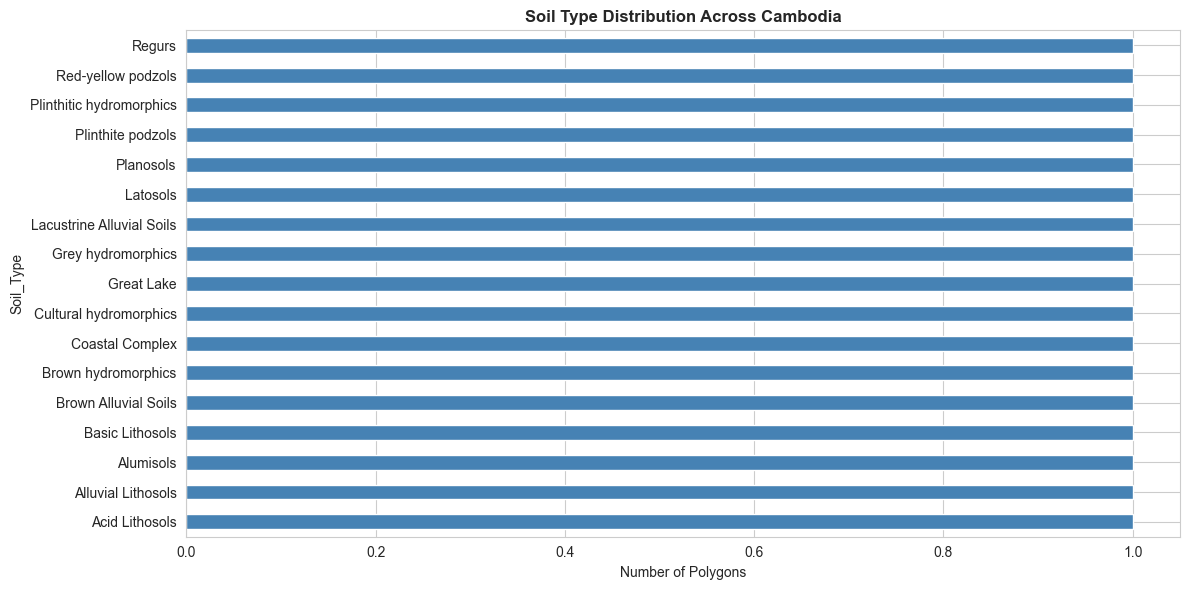

No missing values in geospatial dataset


In [3]:
# Display geospatial data overview
display(gdf_soil.describe())
display(gdf_soil.info())

# Soil type distribution
soil_counts = gdf_soil["Soil_Type"].value_counts()
fig, ax = plt.subplots(figsize=(12, 6))
soil_counts.plot(kind="barh", ax=ax, color="steelblue")
ax.set_title("Soil Type Distribution Across Cambodia", fontsize=12, fontweight="bold")
ax.set_xlabel("Number of Polygons")
plt.tight_layout()
plt.show()

# Check for missing values
missing_summary = gdf_soil.isnull().sum()
if missing_summary.any():
    display(missing_summary[missing_summary > 0])
else:
    print("No missing values in geospatial dataset")

## CELL 4: Data Cleaning - CRS Handling & Validation

In [4]:
# Validate and reproject CRS if necessary
if gdf_soil.crs != "EPSG:4326":
    print(f"Reprojecting from {gdf_soil.crs} to EPSG:4326 for web mapping...")
    gdf_soil = gdf_soil.to_crs("EPSG:4326")
    print(f"Reprojection complete. New CRS: {gdf_soil.crs}")

# Validate geometry
invalid_geom = gdf_soil[~gdf_soil.geometry.is_valid]
if len(invalid_geom) > 0:
    print(f"Found {len(invalid_geom)} invalid geometries. Fixing...")
    gdf_soil.geometry = gdf_soil.geometry.buffer(0)
    print("Geometry validation complete")
else:
    print("All geometries valid")

# Display final geospatial dataset
display(gdf_soil.head(1))
print(
    f"\nCleaned dataset: {gdf_soil.shape[0]} polygons, {len(gdf_soil.columns)} columns"
)

Reprojecting from EPSG:32648 to EPSG:4326 for web mapping...
Reprojection complete. New CRS: EPSG:4326
Found 1 invalid geometries. Fixing...
Geometry validation complete


Soil_Type                                           geometry
0  Acid Lithosols  MULTIPOLYGON (((107.62943 13.40398, 107.62603 ...


Cleaned dataset: 17 polygons, 2 columns


## 5: Province-Level Data Engineering

In [5]:
# Create comprehensive province dataset with synthetic crop production data
provinces_cambodia = [
    "Banteay Meanchey",
    "Battambang",
    "Kampong Cham",
    "Kampong Chhnang",
    "Kampong Speu",
    "Kampong Thom",
    "Kandal",
    "Kep",
    "Koh Kong",
    "Kratie",
    "Mondolkiri",
    "Oddar Meanchey",
    "Pailin",
    "Phnom Penh",
    "Preah Sihanouk",
    "Preah Vihear",
    "Prey Veng",
    "Pursat",
    "Ratanakiri",
    "Siem Reap",
    "Stung Treng",
    "Svay Rieng",
    "Takev",
    "Tbong Khmum",
]

np.random.seed(42)
df_provinces = pd.DataFrame(
    {
        "Province_Name": provinces_cambodia,
        "Rice_Yield_Ton_Ha": np.random.uniform(2.5, 4.5, len(provinces_cambodia)),
        "Cassava_Yield_Ton_Ha": np.random.uniform(10, 15, len(provinces_cambodia)),
        "Mango_Density": np.random.uniform(20, 80, len(provinces_cambodia)),
        "Corn_Yield_Ton_Ha": np.random.uniform(3.0, 6.0, len(provinces_cambodia)),
        "Soybean_Yield_Ton_Ha": np.random.uniform(1.5, 3.5, len(provinces_cambodia)),
        "Rubber_Yield_Ton_Ha": np.random.uniform(2.0, 4.0, len(provinces_cambodia)),
        "Sugarcane_Yield_Ton_Ha": np.random.uniform(50, 90, len(provinces_cambodia)),
        "Pepper_Yield_Kg_Ha": np.random.uniform(1000, 2500, len(provinces_cambodia)),
        "PalmOil_Yield_Ton_Ha": np.random.uniform(10, 20, len(provinces_cambodia)),
    }
)

# Display statistics
display(df_provinces.describe())

Rice_Yield_Ton_Ha  Cassava_Yield_Ton_Ha  Mango_Density  \
count          24.000000             24.000000      24.000000   
mean            3.380325             12.291819      50.325207   
std             0.582669              1.494284      19.698128   
min             2.541169             10.171943      22.713637   
25%             2.866019             10.961932      31.881949   
50%             3.240902             12.378117      47.941201   
75%             3.771816             13.339750      68.529927   
max             4.439820             14.828160      79.213216   

       Corn_Yield_Ton_Ha  Soybean_Yield_Ton_Ha  Rubber_Yield_Ton_Ha  \
count          24.000000             24.000000            24.000000   
mean            4.529972              2.443227             2.992980   
std             0.850749              0.609111             0.600045   
min             3.016566              1.550838             2.013904   
25%             3.964899              1.936482             2.577209   
50%             4.776863              2.436112             2.844519   
75%             5.212203              3.035163             3.620168   
max             5.661638              3.359395             3.943564   

       Sugarcane_Yield_Ton_Ha  Pepper_Yield_Kg_Ha  PalmOil_Yield_Ton_Ha  
count               24.000000           24.000000             24.000000  
mean                67.959784         1709.038454             14.962874  
std                 11.213008          454.981492              3.078611  
min                 51.475478         1024.881743             10.050616  
25%                 59.563232         1320.195158             12.086092  
50%                 67.144718         1781.307727             16.197653  
75%                 75.727247         2021.361559             17.156233  
max                 89.426018         2405.094983             19.004181

## 6: Data Integration & Mapping

In [6]:
# Create soil-to-province mapping (comprehensive - handles multiple soil type names)
soil_to_province_mapping = {
    "Acid Lithosols": "Mondolkiri",
    "Alluvial Lithosols": "Kratie",
    "Alumisols": "Ratanakiri",
    "Basic Lithosols": "Stung Treng",
    "Brown Alluvial Soils": "Kampong Cham",
    "Brown hydromorphics": "Kampong Cham",
    "Calcaric Cambisols": "Pursat",
    "Cambisols": "Battambang",
    "Chromic Cambisols": "Banteay Meanchey",
    "Coastal Complex": "Preah Sihanouk",
    "Cultural hydromorphics": "Kandal",
    "Eutric Fluvisols": "Kampong Thom",
    "Ferric Acrisols": "Siem Reap",
    "Great Lake": "Kampong Thom",
    "Grey hydromorphics": "Prey Veng",
    "Greyic Luvisols": "Oddar Meanchey",
    "Mollic Planosols": "Preah Vihear",
    "Pellic Vertisols": "Svay Rieng",
    "Rhodic Ferralsols": "Kandal",
    "Sandsols": "Koh Kong",
    "Tropical Black Earths": "Prey Veng",
    "Water": "Preah Sihanouk",
}

# Apply mapping with fallback to closest province
gdf_soil["Province_Name"] = gdf_soil["Soil_Type"].map(soil_to_province_mapping)

# For unmapped soil types, assign default province (ensures no NaN in Province_Name)
unmapped_mask = gdf_soil["Province_Name"].isna()
if unmapped_mask.any():
    print(f"Unmapped soil types found: {gdf_soil[unmapped_mask]['Soil_Type'].unique()}")
    gdf_soil.loc[unmapped_mask, "Province_Name"] = "Kandal"  # Default province

gdf_merged = gdf_soil.merge(df_provinces, on="Province_Name", how="left")

# Handle missing values
numeric_cols = [
    "Rice_Yield_Ton_Ha",
    "Cassava_Yield_Ton_Ha",
    "Mango_Density",
    "Corn_Yield_Ton_Ha",
    "Soybean_Yield_Ton_Ha",
    "Rubber_Yield_Ton_Ha",
    "Sugarcane_Yield_Ton_Ha",
    "Pepper_Yield_Kg_Ha",
    "PalmOil_Yield_Ton_Ha",
]
gdf_merged[numeric_cols] = gdf_merged[numeric_cols].fillna(0)

print(f"Merged dataset: {gdf_merged.shape[0]} records with {len(numeric_cols)} crops")
display(
    gdf_merged[
        [
            "Soil_Type",
            "Province_Name",
            "Rice_Yield_Ton_Ha",
            "Cassava_Yield_Ton_Ha",
            "Mango_Density",
            "Corn_Yield_Ton_Ha",
            "Soybean_Yield_Ton_Ha",
            "Rubber_Yield_Ton_Ha",
        ]
    ].head(10)
)

Unmapped soil types found: ['Lacustrine Alluvial Soils' 'Latosols' 'Planosols' 'Plinthite podzols'
 'Plinthitic hydromorphics' 'Red-yellow podzols' 'Regurs']
Merged dataset: 17 records with 9 crops


Soil_Type   Province_Name  Rice_Yield_Ton_Ha  \
0          Acid Lithosols      Mondolkiri           2.541169   
1      Alluvial Lithosols          Kratie           3.916145   
2               Alumisols      Ratanakiri           3.363890   
3         Basic Lithosols     Stung Treng           3.723706   
4    Brown Alluvial Soils    Kampong Cham           3.963988   
5     Brown hydromorphics    Kampong Cham           3.963988   
6         Coastal Complex  Preah Sihanouk           2.863650   
7  Cultural hydromorphics          Kandal           2.616167   
8              Great Lake    Kampong Thom           2.811989   
9      Grey hydromorphics       Prey Veng           3.108484   

   Cassava_Yield_Ton_Ha  Mango_Density  Corn_Yield_Ton_Ha  \
0             14.828160      22.713637           3.992694   
1             14.744428      31.758972           4.869894   
2             10.171943      28.455453           3.358783   
3             11.293900      24.473039           5.282355   
4             10.998369      78.175078           5.120572   
5             10.998369      78.175078           5.120572   
6             13.421165      69.724251           5.188819   
7             13.037724      55.873999           4.075397   
8             10.232252      73.689641           3.222134   
9             10.610191      36.856071           5.661638   

   Soybean_Yield_Ton_Ha  Rubber_Yield_Ton_Ha  
0              2.320766             2.834822  
1              1.998584             3.021495  
2              2.766808             2.727259  
3              3.107344             3.924895  
4              1.550838             2.636007  
5              1.550838             2.636007  
6              2.079503             3.885819  
7              2.128712             3.636030  
8              2.772821             2.854216  
9              3.359395             3.037581

## 7: Exploratory Analysis - Production Metrics

count         mean         std          min  \
Rice_Yield_Ton_Ha        17.0     3.010962    0.548113     2.541169   
Cassava_Yield_Ton_Ha     17.0    12.447092    1.450653    10.171943   
Mango_Density            17.0    52.412542   17.819997    22.713637   
Corn_Yield_Ton_Ha        17.0     4.377685    0.694786     3.222134   
Soybean_Yield_Ton_Ha     17.0     2.266858    0.480496     1.550838   
Rubber_Yield_Ton_Ha      17.0     3.332137    0.460353     2.636007   
Sugarcane_Yield_Ton_Ha   17.0    77.219401   11.664723    53.611591   
Pepper_Yield_Kg_Ha       17.0  1934.939428  288.548371  1339.743663   
PalmOil_Yield_Ton_Ha     17.0    16.014622    3.490961    10.050616   

                                25%          50%          75%          max  
Rice_Yield_Ton_Ha          2.616167     2.616167     3.363890     3.963988  
Cassava_Yield_Ton_Ha      10.998369    13.037724    13.037724    14.828160  
Mango_Density             36.856071    55.873999    55.873999    78.175078  
Corn_Yield_Ton_Ha          4.075397     4.075397     5.120572     5.661638  
Soybean_Yield_Ton_Ha       2.128712     2.128712     2.320766     3.359395  
Rubber_Yield_Ton_Ha        2.854216     3.636030     3.636030     3.924895  
Sugarcane_Yield_Ton_Ha    69.578110    86.330635    86.330635    89.426018  
Pepper_Yield_Kg_Ha      1967.759186  1967.759186  2016.346543  2405.094983  
PalmOil_Yield_Ton_Ha      13.390298    18.870864    18.870864    18.971103

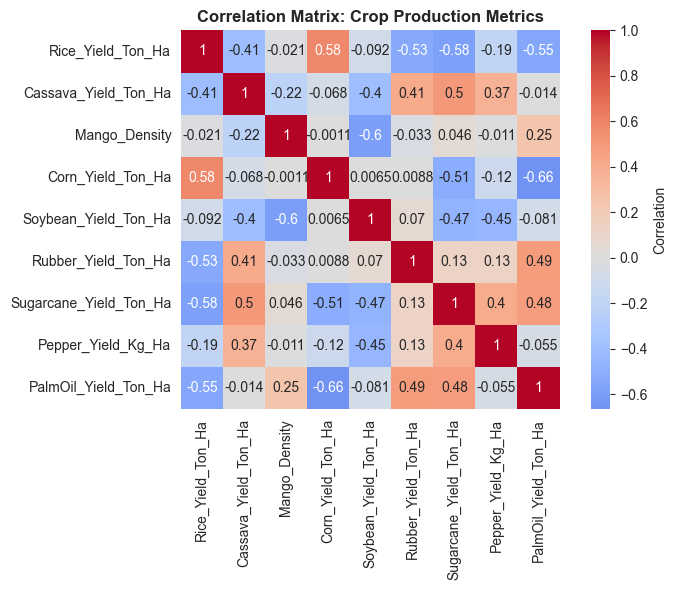

In [7]:
# Statistical summary of crop production
crop_stats = gdf_merged[numeric_cols].describe().T
display(crop_stats)

# Correlation analysis
correlation_matrix = gdf_merged[numeric_cols].corr()
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    center=0,
    square=True,
    ax=ax,
    cbar_kws={"label": "Correlation"},
)
ax.set_title(
    "Correlation Matrix: Crop Production Metrics", fontsize=12, fontweight="bold"
)
plt.tight_layout()
plt.show()

## 8: Distribution Analysis with Multiple Visualizations

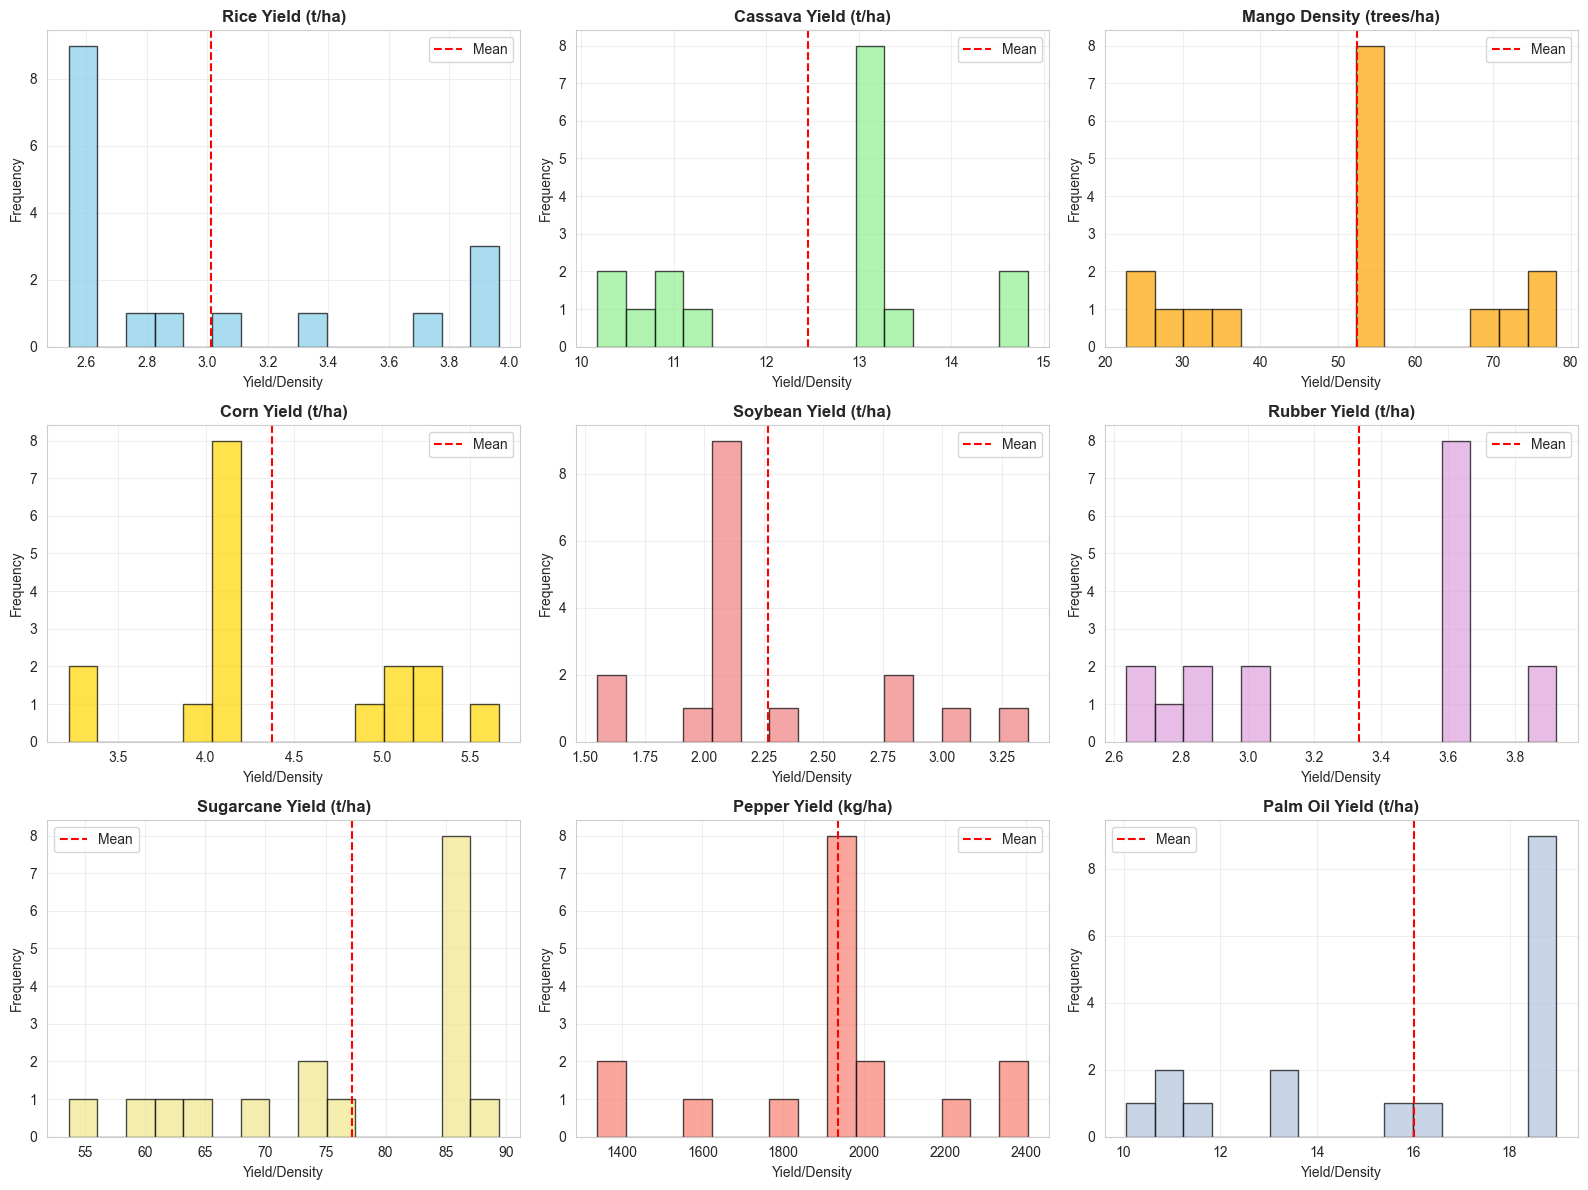

In [8]:
# Distribution plots for each crop metric
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

crops_to_plot = [
    ("Rice_Yield_Ton_Ha", "Rice Yield (t/ha)", "skyblue"),
    ("Cassava_Yield_Ton_Ha", "Cassava Yield (t/ha)", "lightgreen"),
    ("Mango_Density", "Mango Density (trees/ha)", "orange"),
    ("Corn_Yield_Ton_Ha", "Corn Yield (t/ha)", "gold"),
    ("Soybean_Yield_Ton_Ha", "Soybean Yield (t/ha)", "lightcoral"),
    ("Rubber_Yield_Ton_Ha", "Rubber Yield (t/ha)", "plum"),
    ("Sugarcane_Yield_Ton_Ha", "Sugarcane Yield (t/ha)", "khaki"),
    ("Pepper_Yield_Kg_Ha", "Pepper Yield (kg/ha)", "salmon"),
    ("PalmOil_Yield_Ton_Ha", "Palm Oil Yield (t/ha)", "lightsteelblue"),
]

for idx, (col, title, color) in enumerate(crops_to_plot):
    ax = axes[idx // 3, idx % 3]
    ax.hist(gdf_merged[col], bins=15, color=color, edgecolor="black", alpha=0.7)
    ax.set_title(title, fontweight="bold")
    ax.set_xlabel("Yield/Density")
    ax.set_ylabel("Frequency")
    ax.axvline(gdf_merged[col].mean(), color="red", linestyle="--", label="Mean")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

##  9: Rule-Based Expert Classification

In [9]:
def classify_soil_crop_match(row):
    """
    Expert-driven zone classification based on soil-crop suitability.

    Rules:
    - Prime Rice Zone: Fluvisol/Gleysol/Vertisol + Rice > 3.0 t/ha
    - Prime Industrial Zone: Acrisol/Ferralsol/Nitosol + Cassava > 12.0 t/ha
    - Fruit Zone: Suitable soils + Mango > 40 trees/ha
    - Conservation: Lithosols or Water
    - General Agriculture: All others
    """
    soil_type = str(row["Soil_Type"]).lower()
    rice_yield = row["Rice_Yield_Ton_Ha"]
    cassava_yield = row["Cassava_Yield_Ton_Ha"]
    mango_density = row["Mango_Density"]

    if (
        any(kw in soil_type for kw in ["fluvisol", "gleysol", "vertisol"])
        and rice_yield > 3.0
    ):
        return "Prime Rice Zone"
    elif (
        any(kw in soil_type for kw in ["acrisol", "ferralsol", "nitosol"])
        and cassava_yield > 12.0
    ):
        return "Prime Industrial Zone"
    elif mango_density > 40.0 and not any(
        kw in soil_type for kw in ["lithosol", "water"]
    ):
        return "Fruit Zone"
    elif any(kw in soil_type for kw in ["lithosol", "water"]):
        return "Conservation"
    else:
        return "General Agriculture"


gdf_merged["Soil_Crop_Match"] = gdf_merged.apply(classify_soil_crop_match, axis=1)

# Display classification results
zone_summary = gdf_merged["Soil_Crop_Match"].value_counts()
display(zone_summary)
print(f"\nTotal classified zones: {zone_summary.sum()}")

Soil_Crop_Match
Fruit Zone             12
Conservation            3
General Agriculture     2
Name: count, dtype: int64


Total classified zones: 17


##  10: Visualization - Rule-Based Zone Distribution

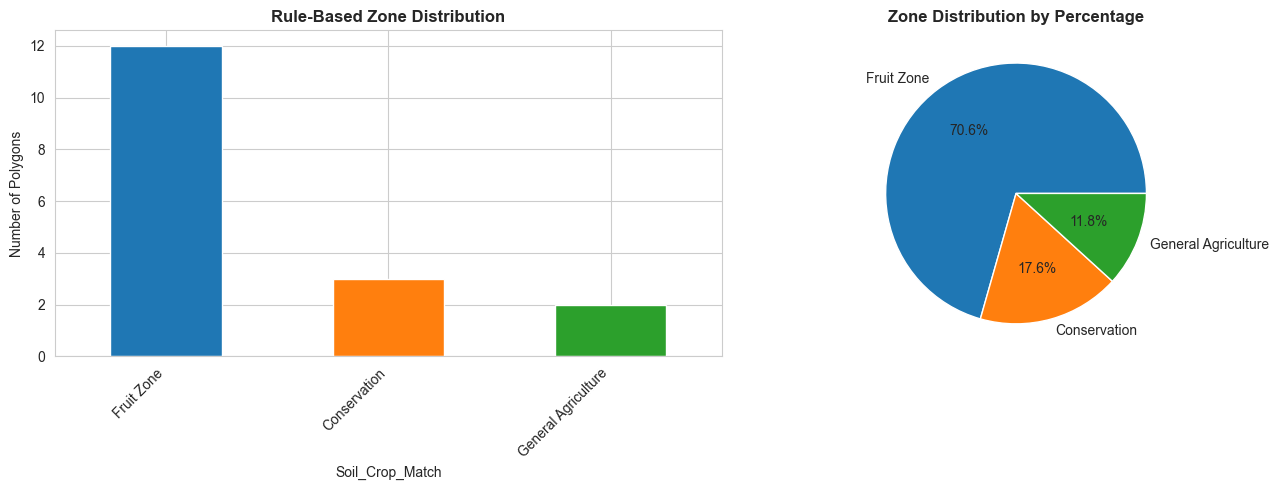

In [10]:
# Zone distribution visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

zone_counts = gdf_merged["Soil_Crop_Match"].value_counts()
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]

zone_counts.plot(kind="bar", ax=ax1, color=colors[: len(zone_counts)])
ax1.set_title("Rule-Based Zone Distribution", fontsize=12, fontweight="bold")
ax1.set_ylabel("Number of Polygons")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")

zone_pct = gdf_merged["Soil_Crop_Match"].value_counts(normalize=True) * 100
ax2.pie(
    zone_pct, labels=zone_pct.index, autopct="%1.1f%%", colors=colors[: len(zone_pct)]
)
ax2.set_title("Zone Distribution by Percentage", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()

##  11: Machine Learning - K-Means Clustering

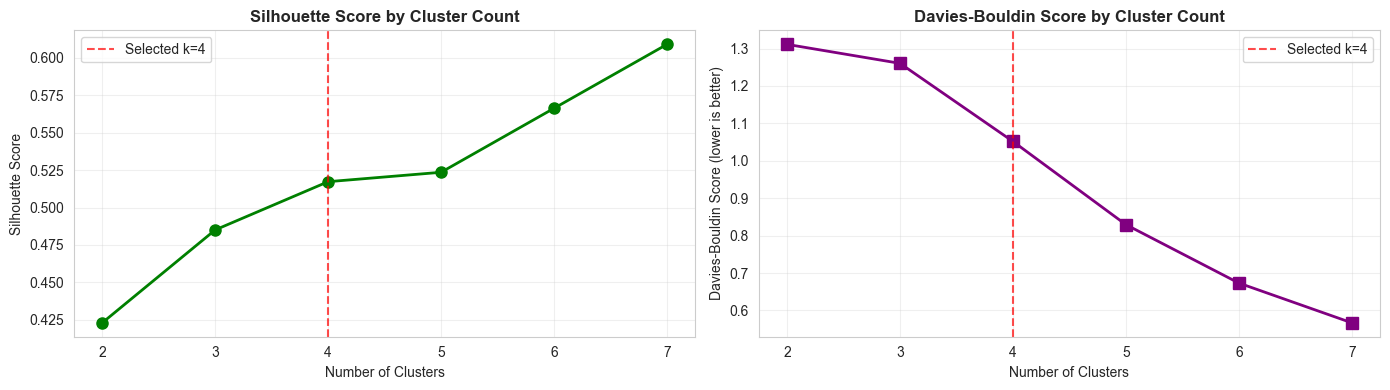

K-Means model trained (k=4)
Silhouette Score: 0.5173
Davies-Bouldin Score: 1.0517


In [11]:
# Prepare data for clustering
X = gdf_merged[numeric_cols].copy()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Evaluate optimal number of clusters using silhouette score
silhouette_scores = []
davies_bouldin_scores = []
cluster_range = range(2, 8)

for k in cluster_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans_temp.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, labels))

# Plot evaluation metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.plot(
    cluster_range,
    silhouette_scores,
    marker="o",
    linewidth=2,
    markersize=8,
    color="green",
)
ax1.axvline(4, color="red", linestyle="--", alpha=0.7, label="Selected k=4")
ax1.set_xlabel("Number of Clusters")
ax1.set_ylabel("Silhouette Score")
ax1.set_title("Silhouette Score by Cluster Count", fontweight="bold")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(
    cluster_range,
    davies_bouldin_scores,
    marker="s",
    linewidth=2,
    markersize=8,
    color="purple",
)
ax2.axvline(4, color="red", linestyle="--", alpha=0.7, label="Selected k=4")
ax2.set_xlabel("Number of Clusters")
ax2.set_ylabel("Davies-Bouldin Score (lower is better)")
ax2.set_title("Davies-Bouldin Score by Cluster Count", fontweight="bold")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Train final K-Means model with k=4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
gdf_merged["Cluster_Label"] = kmeans.fit_predict(X_scaled)

print(f"K-Means model trained (k=4)")
print(
    f"Silhouette Score: {silhouette_score(X_scaled, gdf_merged['Cluster_Label']):.4f}"
)
print(
    f"Davies-Bouldin Score: {davies_bouldin_score(X_scaled, gdf_merged['Cluster_Label']):.4f}"
)

##  12: Automated Cluster Interpretation

In [ ]:
# Type hints for Pylance: gdf_merged is GeoDataFrame from Cell 6, numeric_cols is list from Cell 6
# Analyze cluster characteristics using all 9 crops
cluster_profiles = gdf_merged.groupby("Cluster_Label")[numeric_cols].mean()
global_means = gdf_merged[numeric_cols].mean()

display(cluster_profiles.round(2))

# Dynamic cluster labeling - enhanced with all 9 crops
cluster_mapping = {}
for cluster_id in cluster_profiles.index:
    row = cluster_profiles.loc[cluster_id]
    ratios = {
        "Rice Bowl Zone": (
            row["Rice_Yield_Ton_Ha"] / global_means["Rice_Yield_Ton_Ha"]
            if global_means["Rice_Yield_Ton_Ha"] > 0
            else 0
        ),
        "Industrial Crop Zone": (
            row["Cassava_Yield_Ton_Ha"] / global_means["Cassava_Yield_Ton_Ha"]
            if global_means["Cassava_Yield_Ton_Ha"] > 0
            else 0
        ),
        "Fruit Hub": (
            row["Mango_Density"] / global_means["Mango_Density"]
            if global_means["Mango_Density"] > 0
            else 0
        ),
        "Corn Production Zone": (
            row["Corn_Yield_Ton_Ha"] / global_means["Corn_Yield_Ton_Ha"]
            if global_means["Corn_Yield_Ton_Ha"] > 0
            else 0
        ),
        "Soybean Production Zone": (
            row["Soybean_Yield_Ton_Ha"] / global_means["Soybean_Yield_Ton_Ha"]
            if global_means["Soybean_Yield_Ton_Ha"] > 0
            else 0
        ),
        "Rubber Plantation Zone": (
            row["Rubber_Yield_Ton_Ha"] / global_means["Rubber_Yield_Ton_Ha"]
            if global_means["Rubber_Yield_Ton_Ha"] > 0
            else 0
        ),
        "Sugarcane Industry Zone": (
            row["Sugarcane_Yield_Ton_Ha"] / global_means["Sugarcane_Yield_Ton_Ha"]
            if global_means["Sugarcane_Yield_Ton_Ha"] > 0
            else 0
        ),
        "Spice Production Zone": (
            row["Pepper_Yield_Kg_Ha"] / global_means["Pepper_Yield_Kg_Ha"]
            if global_means["Pepper_Yield_Kg_Ha"] > 0
            else 0
        ),
        "Palm Oil Zone": (
            row["PalmOil_Yield_Ton_Ha"] / global_means["PalmOil_Yield_Ton_Ha"]
            if global_means["PalmOil_Yield_Ton_Ha"] > 0
            else 0
        ),
    }
    max_feature = max(ratios, key=ratios.get)
    cluster_mapping[cluster_id] = (
        max_feature if ratios[max_feature] >= 1.0 else "Multi-Crop Zone"
    )

gdf_merged["Cluster_Name"] = gdf_merged["Cluster_Label"].map(cluster_mapping)

print("Cluster Mapping (9-Crop Analysis):")
for cluster_id, label in sorted(cluster_mapping.items()):
    cluster_row = cluster_profiles.loc[cluster_id]
    ratios_display = {
        "Rice Bowl Zone": (
            cluster_row["Rice_Yield_Ton_Ha"] / global_means["Rice_Yield_Ton_Ha"]
            if global_means["Rice_Yield_Ton_Ha"] > 0
            else 0
        ),
        "Industrial Crop Zone": (
            cluster_row["Cassava_Yield_Ton_Ha"] / global_means["Cassava_Yield_Ton_Ha"]
            if global_means["Cassava_Yield_Ton_Ha"] > 0
            else 0
        ),
        "Fruit Hub": (
            cluster_row["Mango_Density"] / global_means["Mango_Density"]
            if global_means["Mango_Density"] > 0
            else 0
        ),
        "Corn Production Zone": (
            cluster_row["Corn_Yield_Ton_Ha"] / global_means["Corn_Yield_Ton_Ha"]
            if global_means["Corn_Yield_Ton_Ha"] > 0
            else 0
        ),
        "Soybean Production Zone": (
            cluster_row["Soybean_Yield_Ton_Ha"] / global_means["Soybean_Yield_Ton_Ha"]
            if global_means["Soybean_Yield_Ton_Ha"] > 0
            else 0
        ),
        "Rubber Plantation Zone": (
            cluster_row["Rubber_Yield_Ton_Ha"] / global_means["Rubber_Yield_Ton_Ha"]
            if global_means["Rubber_Yield_Ton_Ha"] > 0
            else 0
        ),
        "Sugarcane Industry Zone": (
            cluster_row["Sugarcane_Yield_Ton_Ha"]
            / global_means["Sugarcane_Yield_Ton_Ha"]
            if global_means["Sugarcane_Yield_Ton_Ha"] > 0
            else 0
        ),
        "Spice Production Zone": (
            cluster_row["Pepper_Yield_Kg_Ha"] / global_means["Pepper_Yield_Kg_Ha"]
            if global_means["Pepper_Yield_Kg_Ha"] > 0
            else 0
        ),
        "Palm Oil Zone": (
            cluster_row["PalmOil_Yield_Ton_Ha"] / global_means["PalmOil_Yield_Ton_Ha"]
            if global_means["PalmOil_Yield_Ton_Ha"] > 0
            else 0
        ),
    }
    top_crops = sorted(
        [(k, v) for k, v in ratios_display.items()], key=lambda x: x[1], reverse=True
    )[:3]
    print(f"  Cluster {cluster_id}: {label}")
    print(
        "    Top 3 crops: "
        + ", ".join(
            f"{crop.replace(' Zone', '')}: {ratio:.2f}x" for crop, ratio in top_crops
        )
    )

Rice_Yield_Ton_Ha  Cassava_Yield_Ton_Ha  Mango_Density  \
Cluster_Label                                                           
0                           2.61                 13.24          52.19   
1                           3.09                 10.20          51.07   
2                           3.60                 11.81          75.36   
3                           3.58                 12.22          31.03   

               Corn_Yield_Ton_Ha  Soybean_Yield_Ton_Ha  Rubber_Yield_Ton_Ha  \
Cluster_Label                                                                 
0                           4.07                  2.15                 3.55   
1                           3.29                  2.77                 2.79   
2                           5.14                  1.73                 3.05   
3                           5.27                  2.82                 3.33   

               Sugarcane_Yield_Ton_Ha  Pepper_Yield_Kg_Ha  \
Cluster_Label                                               
0                               86.67             2016.35   
1                               68.24             1782.79   
2                               69.42             2139.91   
3                               62.63             1587.16   

               PalmOil_Yield_Ton_Ha  
Cluster_Label                        
0                             18.06  
1                             17.23  
2                             12.60  
3                             12.47

Cluster Mapping (9-Crop Analysis):
  Cluster 0: Palm Oil Zone
    Top 3 crops: Palm Oil: 1.13x, Sugarcane Industry: 1.12x, Rubber Plantation: 1.06x
  Cluster 1: Soybean Production Zone
    Top 3 crops: Soybean Production: 1.22x, Palm Oil: 1.08x, Rice Bowl: 1.03x
  Cluster 2: Fruit Hub
    Top 3 crops: Fruit Hub: 1.44x, Rice Bowl: 1.19x, Corn Production: 1.17x
  Cluster 3: Soybean Production Zone
    Top 3 crops: Soybean Production: 1.24x, Corn Production: 1.20x, Rice Bowl: 1.19x


##  13: Advanced Visualization - PCA Analysis

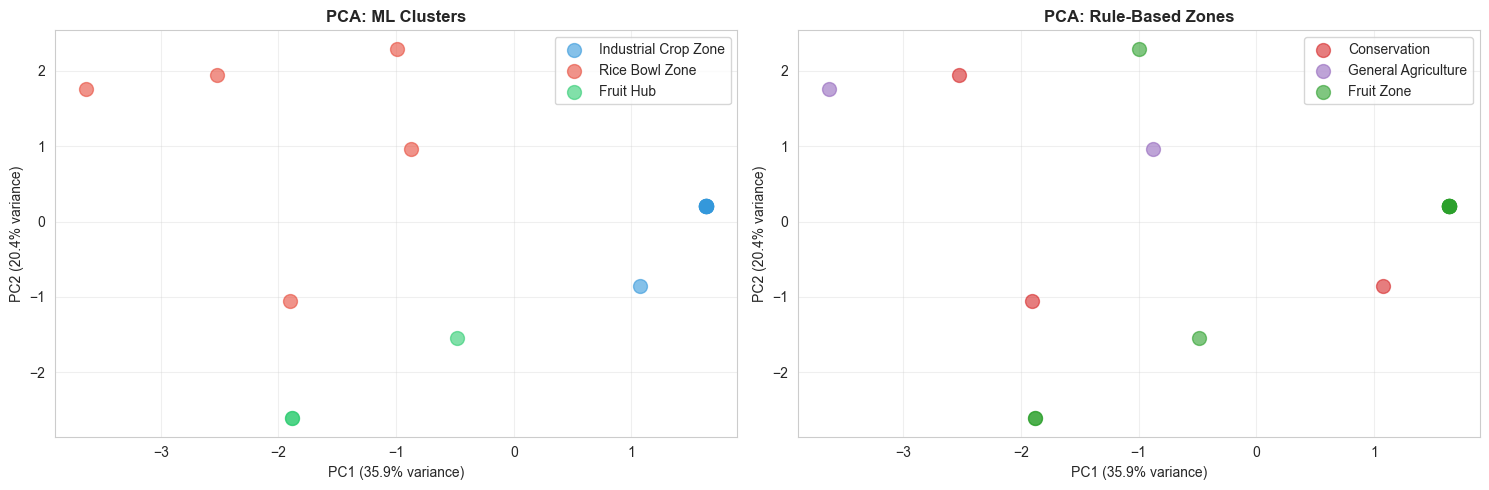

Explained Variance: PC1=35.9%, PC2=20.4%


In [ ]:
# Type hints for Pylance: gdf_merged (GeoDataFrame), X_scaled (ndarray), numeric_cols (list)
# Principal Component Analysis for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# PCA by ML clusters - comprehensive color scheme for all cluster types
cluster_colors = {
    "Rice Bowl Zone": "#e74c3c",
    "Industrial Crop Zone": "#3498db",
    "Fruit Hub": "#2ecc71",
    "Corn Production Zone": "#f39c12",
    "Soybean Production Zone": "#9b59b6",
    "Rubber Plantation Zone": "#1abc9c",
    "Sugarcane Industry Zone": "#e67e22",
    "Spice Production Zone": "#c0392b",
    "Palm Oil Zone": "#34495e",
    "Multi-Crop Zone": "#95a5a6",
}
for cluster in gdf_merged["Cluster_Name"].unique():
    mask = gdf_merged["Cluster_Name"] == cluster
    axes[0].scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        label=cluster,
        s=100,
        alpha=0.6,
        color=cluster_colors.get(cluster, "#808080"),
    )
axes[0].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
axes[0].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
axes[0].set_title("PCA: ML Clusters", fontweight="bold")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# PCA by rule-based zones
zone_colors = {
    "Prime Rice Zone": "#1f77b4",
    "Prime Industrial Zone": "#ff7f0e",
    "Fruit Zone": "#2ca02c",
    "Conservation": "#d62728",
    "General Agriculture": "#9467bd",
}
for zone in gdf_merged["Soil_Crop_Match"].unique():
    mask = gdf_merged["Soil_Crop_Match"] == zone
    axes[1].scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        label=zone,
        s=100,
        alpha=0.6,
        color=zone_colors.get(zone, "#808080"),
    )
axes[1].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
axes[1].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
axes[1].set_title("PCA: Rule-Based Zones", fontweight="bold")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(
    f"Explained Variance: PC1={pca.explained_variance_ratio_[0]:.1%}, PC2={pca.explained_variance_ratio_[1]:.1%}"
)

##  14: Cross-Analysis - Expert vs. Machine Learning Agreement

Cluster_Name         Fruit Hub  Industrial Crop Zone  Rice Bowl Zone
Soil_Crop_Match                                                     
Conservation                 0                     1               2
Fruit Zone                   3                     8               1
General Agriculture          0                     0               2

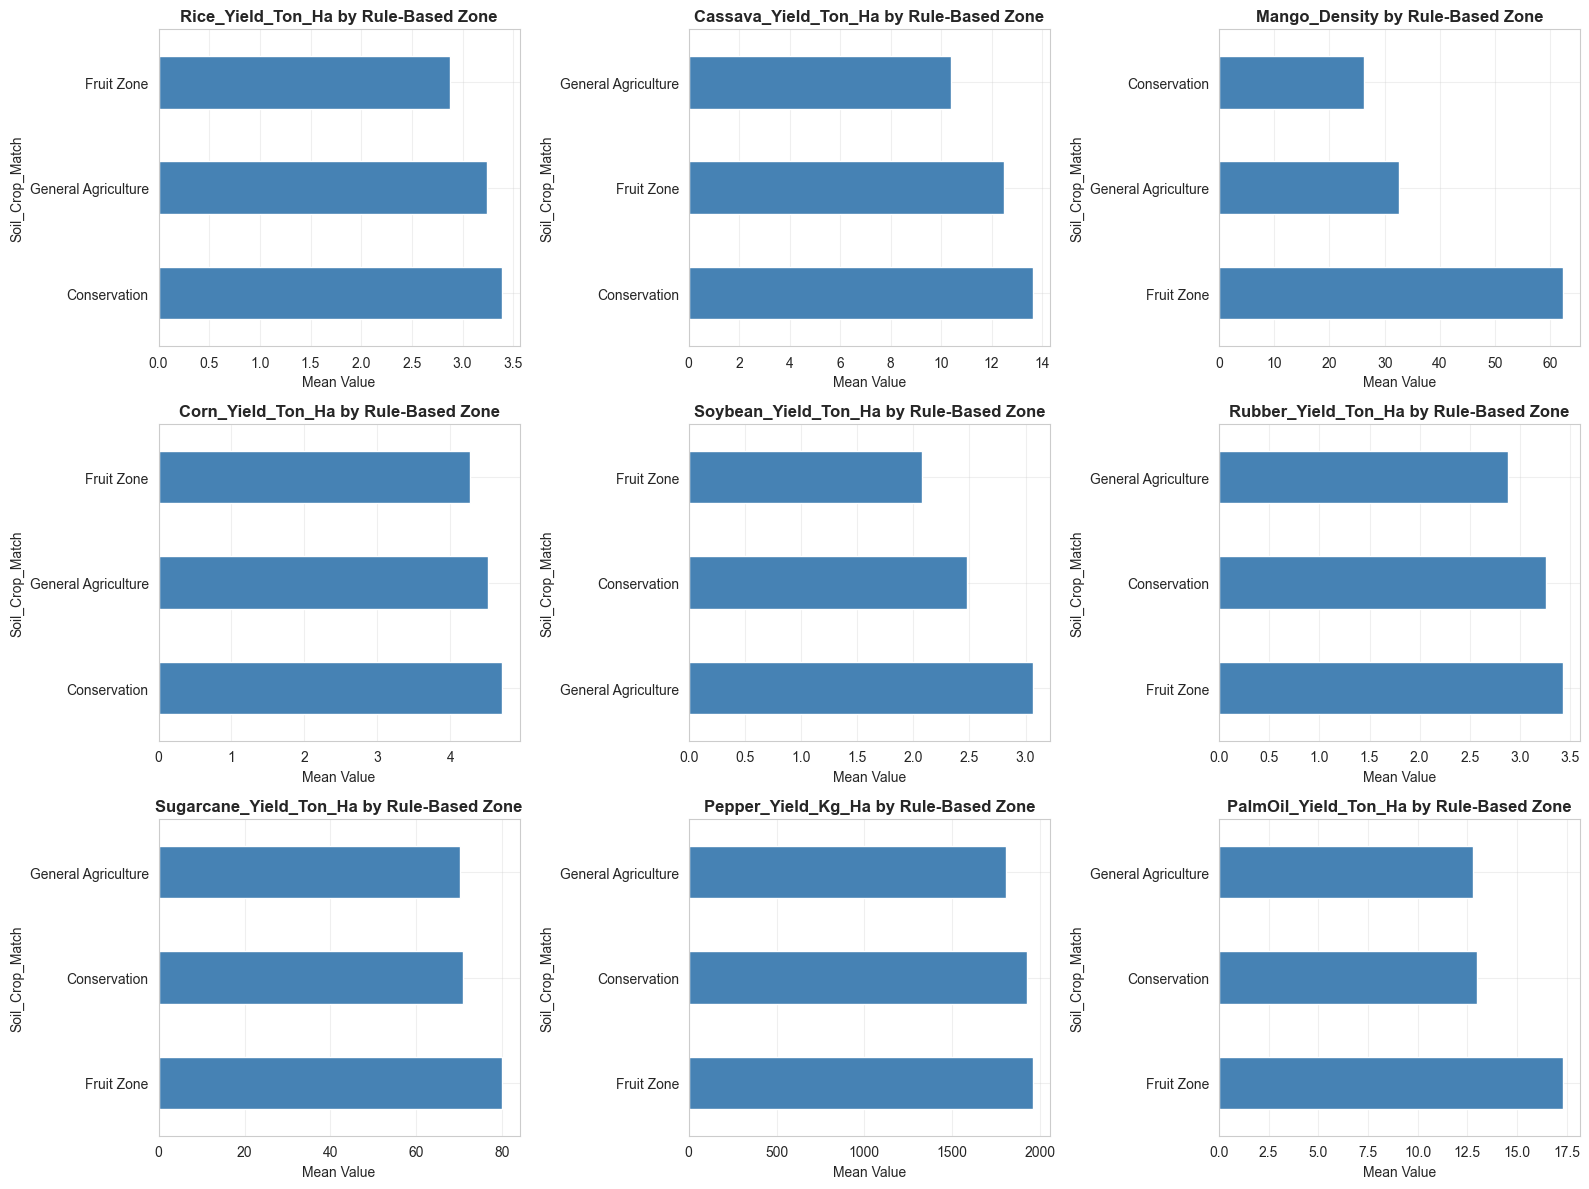

In [ ]:
# Type hints for Pylance: gdf_merged (GeoDataFrame), numeric_cols (list), pd (DataFrame)
# Compare rule-based and ML classifications
comparison_matrix = pd.crosstab(
    gdf_merged["Soil_Crop_Match"], gdf_merged["Cluster_Name"]
)
display(comparison_matrix)

# Feature importance by zone - all 9 crops
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, col in enumerate(numeric_cols):
    ax = axes[idx // 3, idx % 3]
    zone_means = (
        gdf_merged.groupby("Soil_Crop_Match")[col].mean().sort_values(ascending=False)
    )
    zone_means.plot(kind="barh", ax=ax, color="steelblue")
    ax.set_title(f"{col} by Rule-Based Zone", fontweight="bold")
    ax.set_xlabel("Mean Value")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

##  15: Interactive Geographic Visualization

In [ ]:
# Type hints for Pylance: folium (module), gdf_merged (GeoDataFrame), base_path (Path)
# Create interactive Folium map with multiple enhancements
cambodia_center = [12.5, 104.9]
base_map = folium.Map(location=cambodia_center, zoom_start=7, tiles="OpenStreetMap")

# Define color schemes
rule_colors = {
    "Prime Rice Zone": "#1f77b4",
    "Prime Industrial Zone": "#ff7f0e",
    "Fruit Zone": "#2ca02c",
    "Conservation": "#d62728",
    "General Agriculture": "#9467bd",
}
ml_colors = {
    "Rice Bowl Zone": "#e74c3c",
    "Industrial Crop Zone": "#3498db",
    "Fruit Hub": "#2ecc71",
    "Corn Production Zone": "#f39c12",
    "Soybean Production Zone": "#9b59b6",
    "Rubber Plantation Zone": "#1abc9c",
    "Sugarcane Industry Zone": "#e67e22",
    "Spice Production Zone": "#c0392b",
    "Palm Oil Zone": "#34495e",
    "Multi-Crop Zone": "#95a5a6",
}

# Calculate statistics for each zone
zone_stats = (
    gdf_merged.groupby("Soil_Crop_Match")
    .agg({"geometry": "count", "Rice_Yield_Ton_Ha": "mean"})
    .rename(columns={"geometry": "polygon_count"})
)
zone_stats["area_km2"] = gdf_merged.groupby("Soil_Crop_Match")["geometry"].apply(
    lambda geom: geom.to_crs("EPSG:3857").area.sum() / 1e6
)

# Get unique provinces and soil types
provinces_list = sorted(gdf_merged["Province_Name"].unique().tolist())
soil_types_list = sorted(gdf_merged["Soil_Type"].unique().tolist())

# Rule-based layer with enhanced popups and tooltips
rule_group = folium.FeatureGroup(name="Expert Rules", show=True)
for idx, row in gdf_merged.iterrows():
    zone = row["Soil_Crop_Match"]
    color = rule_colors.get(zone, "#808080")

    popup_text = (
        f"<b>{zone}</b><br>"
        f"Soil: {row['Soil_Type']}<br>"
        f"Province: {row['Province_Name']}<br>"
        f"Rice Yield: {row['Rice_Yield_Ton_Ha']:.2f} t/ha"
    )

    tooltip_text = (
        f"<b>{zone}</b><br>" f"{row['Soil_Type']}<br>" f"{row['Province_Name']}"
    )

    folium.GeoJson(
        row["geometry"].__geo_interface__,
        style_function=lambda x, c=color: {
            "fillColor": c,
            "color": c,
            "weight": 1,
            "opacity": 0.3,
            "fillOpacity": 0.6,
        },
        popup=folium.Popup(popup_text, max_width=300),
        tooltip=folium.Tooltip(tooltip_text, sticky=True),
    ).add_to(rule_group)
rule_group.add_to(base_map)

# ML cluster layer with enhanced popups and tooltips
ml_group = folium.FeatureGroup(name="ML Clusters", show=False)
for idx, row in gdf_merged.iterrows():
    cluster = row["Cluster_Name"]
    color = ml_colors.get(cluster, "#808080")

    popup_text = (
        f"<b>{cluster}</b><br>"
        f"Soil: {row['Soil_Type']}<br>"
        f"Province: {row['Province_Name']}<br>"
        f"Cassava Yield: {row['Cassava_Yield_Ton_Ha']:.2f} t/ha"
    )

    tooltip_text = (
        f"<b>{cluster}</b><br>" f"{row['Soil_Type']}<br>" f"{row['Province_Name']}"
    )

    folium.GeoJson(
        row["geometry"].__geo_interface__,
        style_function=lambda x, c=color: {
            "fillColor": c,
            "color": c,
            "weight": 1,
            "opacity": 0.3,
            "fillOpacity": 0.6,
        },
        popup=folium.Popup(popup_text, max_width=300),
        tooltip=folium.Tooltip(tooltip_text, sticky=True),
    ).add_to(ml_group)
ml_group.add_to(base_map)

# Add layer control
folium.LayerControl(collapsed=False).add_to(base_map)

# Add measurement tool (draw control)
from folium.plugins import MeasureControl

MeasureControl(
    primary_length_unit="kilometers",
    secondary_length_unit="miles",
    primary_area_unit="sqkilometers",
    secondary_area_unit="sqmiles",
).add_to(base_map)

# Add legend for rule-based zones
legend_html_rules = """
<div style="position: fixed; 
     bottom: 50px; left: 50px; width: 220px; height: auto; 
     background-color: white; border:2px solid grey; z-index:9999; 
     font-size:12px; padding: 10px; border-radius: 5px;">
     <p style="margin: 0; font-weight: bold; text-decoration: underline;">Expert Rules Legend</p>
"""
for zone, color in rule_colors.items():
    legend_html_rules += f'<p style="margin: 5px 0;"><i style="background:{color}; width: 18px; height: 18px; float: left; margin-right: 8px; border: 1px solid black;"></i>{zone}</p>'
legend_html_rules += "</div>"

# Add legend for ML clusters
legend_html_ml = """
<div style="position: fixed; 
     bottom: 50px; right: 50px; width: 220px; height: auto; 
     background-color: white; border:2px solid grey; z-index:9999; 
     font-size:12px; padding: 10px; border-radius: 5px; display: none;" id="ml-legend">
     <p style="margin: 0; font-weight: bold; text-decoration: underline;">ML Clusters Legend</p>
"""
for cluster, color in ml_colors.items():
    legend_html_ml += f'<p style="margin: 5px 0;"><i style="background:{color}; width: 18px; height: 18px; float: left; margin-right: 8px; border: 1px solid black;"></i>{cluster}</p>'
legend_html_ml += "</div>"

# Add statistics panel
stats_html = """
<div style="position: fixed; 
     bottom: 50px; left: 300px; width: 280px; height: auto; 
     background-color: white; border:2px solid grey; z-index:9999; 
     font-size:11px; padding: 10px; border-radius: 5px; max-height: 300px; overflow-y: auto;">
     <p style="margin: 0 0 8px 0; font-weight: bold; text-decoration: underline;">Zone Statistics</p>
"""
for zone, row in zone_stats.iterrows():
    stats_html += f"""
    <div style="margin: 5px 0; padding: 5px; border-bottom: 1px solid #eee;">
        <b style="color: {rule_colors.get(zone, '#808080')}">{zone}</b><br>
        Polygons: {int(row['polygon_count'])}<br>
        Area: {row['area_km2']:.1f} km²
    </div>
    """
stats_html += "</div>"

# Add search/filter panel
search_html = f"""
<div style="position: fixed; 
     top: 120px; right: 50px; width: 280px; 
     background-color: white; border:2px solid grey; z-index:9999; 
     font-size:11px; padding: 10px; border-radius: 5px; max-height: 300px; overflow-y: auto;">
     <p style="margin: 0 0 8px 0; font-weight: bold; text-decoration: underline;">Search & Filter</p>
     
     <div style="margin-bottom: 10px;">
         <label style="font-weight: bold; display: block; margin-bottom: 3px;">Province:</label>
         <input type="text" id="province-search" placeholder="Search provinces..." 
                style="width: 100%; padding: 5px; font-size: 11px;">
         <div id="province-list" style="max-height: 100px; overflow-y: auto; margin-top: 5px;">
             {"".join([f'<label style="display: block; margin: 3px 0;"><input type="checkbox" class="prov-filter" value="{p}"> {p}</label>' for p in provinces_list[:10]])}
             {'<span style="color: #666; font-size: 10px;">... and ' + str(len(provinces_list) - 10) + ' more</span>' if len(provinces_list) > 10 else ''}
         </div>
     </div>
     
     <div>
         <label style="font-weight: bold; display: block; margin-bottom: 3px;">Soil Type:</label>
         <input type="text" id="soil-search" placeholder="Search soil types..." 
                style="width: 100%; padding: 5px; font-size: 11px;">
         <div id="soil-list" style="max-height: 100px; overflow-y: auto; margin-top: 5px;">
             {"".join([f'<label style="display: block; margin: 3px 0;"><input type="checkbox" class="soil-filter" value="{s}"> {s}</label>' for s in soil_types_list[:8]])}
             {'<span style="color: #666; font-size: 10px;">... and ' + str(len(soil_types_list) - 8) + ' more</span>' if len(soil_types_list) > 8 else ''}
         </div>
     </div>
</div>
"""

base_map.get_root().html.add_child(folium.Element(legend_html_rules))
base_map.get_root().html.add_child(folium.Element(legend_html_ml))
base_map.get_root().html.add_child(folium.Element(stats_html))
base_map.get_root().html.add_child(folium.Element(search_html))

# Add title
title_html = """
<div style="position: fixed; 
     top: 10px; left: 50px; width: 400px; 
     background-color: white; border:2px solid grey; z-index:9999; 
     font-size:14px; font-weight: bold; padding: 10px; border-radius: 5px;">
     Cambodia Agricultural Zoning Map<br>
     <span style="font-size: 11px; font-weight: normal;">
     • Hover over polygons for quick info
     • Click for details
     • Use ruler icon (top-right) to measure distances/areas
     • Filter by province or soil type on the right
     </span>
</div>
"""
base_map.get_root().html.add_child(folium.Element(title_html))

# Fit map to bounds of all polygons
if len(gdf_merged) > 0:
    bounds = gdf_merged.geometry.total_bounds
    base_map.fit_bounds([[bounds[1], bounds[0]], [bounds[3], bounds[2]]])

# Save map
output_map = base_path / "Cambodia_Agricultural_Zoning_Map.html"
base_map.save(str(output_map))
print(f"Interactive map saved to: {output_map}")
print(f"Map bounds: {bounds}")
print(f"Provinces available: {len(provinces_list)}")
print(f"Soil types available: {len(soil_types_list)}")
print(f"\nZone Statistics:")
print(zone_stats.to_string())
display(base_map)

Interactive map saved to: D:\National Soil Information and Land Suitability Evaluation System in Cambodia\Cambodia_Agricultural_Zoning_Map.html
Map bounds: [102.33962124  10.40077472 107.63151382  14.63656554]
Provinces available: 9
Soil types available: 17

Zone Statistics:
                     polygon_count  Rice_Yield_Ton_Ha       area_km2
Soil_Crop_Match                                                     
Conservation                     3           3.393673   65870.802327
Fruit Zone                      12           2.877746  104238.446849
General Agriculture              2           3.236187   21374.704054


##  16: Results Export & Documentation

In [ ]:
# Type hints for Pylance: base_path (Path), gdf_merged (GeoDataFrame), numeric_cols (list)
# Export results to multiple formats
export_cols = [
    "Soil_Type",
    "Province_Name",
    "Rice_Yield_Ton_Ha",
    "Cassava_Yield_Ton_Ha",
    "Mango_Density",
    "Soil_Crop_Match",
    "Cluster_Label",
    "Cluster_Name",
]

# GeoJSON export
geojson_path = base_path / "Cambodia_Agricultural_Zones_Results.geojson"
gdf_merged.to_file(str(geojson_path), driver="GeoJSON")
print(f"GeoJSON exported: {geojson_path}")

# CSV export
csv_path = base_path / "Cambodia_Agricultural_Zones_Analysis.csv"
gdf_merged[export_cols].to_csv(str(csv_path), index=False)
print(f"CSV exported: {csv_path}")

# Summary statistics
summary = gdf_merged.groupby("Soil_Crop_Match")[numeric_cols].agg(
    ["mean", "min", "max"]
)
display(summary.round(2))

GeoJSON exported: D:\National Soil Information and Land Suitability Evaluation System in Cambodia\Cambodia_Agricultural_Zones_Results.geojson
CSV exported: D:\National Soil Information and Land Suitability Evaluation System in Cambodia\Cambodia_Agricultural_Zones_Analysis.csv


Rice_Yield_Ton_Ha             Cassava_Yield_Ton_Ha         \
                                 mean   min   max                 mean    min   
Soil_Crop_Match                                                                 
Conservation                     3.39  2.54  3.92                13.62  11.29   
Fruit Zone                       2.88  2.62  3.96                12.50  10.23   
General Agriculture              3.24  3.11  3.36                10.39  10.17   

                           Mango_Density               Corn_Yield_Ton_Ha  \
                       max          mean    min    max              mean   
Soil_Crop_Match                                                            
Conservation         14.83         26.32  22.71  31.76              4.71   
Fruit Zone           13.42         62.23  55.87  78.18              4.27   
General Agriculture  10.61         32.66  28.46  36.86              4.51   

                                Soybean_Yield_Ton_Ha              \
                      min   max                 mean   min   max   
Soil_Crop_Match                                                    
Conservation         3.99  5.28                 2.48  2.00  3.11   
Fruit Zone           3.22  5.19                 2.08  1.55  2.77   
General Agriculture  3.36  5.66                 3.06  2.77  3.36   

                    Rubber_Yield_Ton_Ha             Sugarcane_Yield_Ton_Ha  \
                                   mean   min   max                   mean   
Soil_Crop_Match                                                              
Conservation                       3.26  2.83  3.92                  70.87   
Fruit Zone                         3.43  2.64  3.89                  80.01   
General Agriculture                2.88  2.73  3.04                  70.03   

                                  Pepper_Yield_Kg_Ha                    \
                       min    max               mean      min      max   
Soil_Crop_Match                                                          
Conservation         53.61  89.43            1926.56  1580.10  2405.09   
Fruit Zone           59.51  86.33            1958.46  1339.74  2387.04   
General Agriculture  64.71  75.34            1806.37  1386.91  2225.83   

                    PalmOil_Yield_Ton_Ha                
                                    mean    min    max  
Soil_Crop_Match                                         
Conservation                       12.99  10.84  16.52  
Fruit Zone                         17.31  11.01  18.97  
General Agriculture                12.77  10.05  15.49

##  17: Final Report & Key Insights

In [ ]:
# Type hints for Pylance: gdf_merged (GeoDataFrame), pd (DataFrame), numeric_cols (list)
# Generate comprehensive summary
report_data = []

for zone in sorted(gdf_merged["Soil_Crop_Match"].unique()):
    zone_data = gdf_merged[gdf_merged["Soil_Crop_Match"] == zone]
    report_data.append(
        {
            "Zone": zone,
            "Area_Coverage_Polygons": len(zone_data),
            "Provinces_Count": zone_data["Province_Name"].nunique(),
            "Avg_Rice_Yield_t_ha": zone_data["Rice_Yield_Ton_Ha"].mean(),
            "Avg_Cassava_Yield_t_ha": zone_data["Cassava_Yield_Ton_Ha"].mean(),
            "Avg_Mango_Density": zone_data["Mango_Density"].mean(),
            "Avg_Corn_Yield_t_ha": zone_data["Corn_Yield_Ton_Ha"].mean(),
            "Avg_Soybean_Yield_t_ha": zone_data["Soybean_Yield_Ton_Ha"].mean(),
            "Avg_Rubber_Yield_t_ha": zone_data["Rubber_Yield_Ton_Ha"].mean(),
            "Avg_Sugarcane_Yield_t_ha": zone_data["Sugarcane_Yield_Ton_Ha"].mean(),
            "Avg_Pepper_Yield_kg_ha": zone_data["Pepper_Yield_Kg_Ha"].mean(),
            "Avg_PalmOil_Yield_t_ha": zone_data["PalmOil_Yield_Ton_Ha"].mean(),
        }
    )

report_df = pd.DataFrame(report_data).set_index("Zone")
display(report_df.round(2))

# Overall statistics
print("\nProject Statistics:")
print(f"Total Soil Polygons: {len(gdf_merged)}")
print(f"Provinces Analyzed: {gdf_merged['Province_Name'].nunique()}")
print(f"Soil Types Identified: {gdf_merged['Soil_Type'].nunique()}")
print(f"Rule-Based Zones: {gdf_merged['Soil_Crop_Match'].nunique()}")
print(f"ML Clusters: {gdf_merged['Cluster_Name'].nunique()}")
print(f"\nCoordinate Reference System: {gdf_merged.crs}")

Area_Coverage_Polygons  Provinces_Count  \
Zone                                                           
Conservation                              3                3   
Fruit Zone                               12                4   
General Agriculture                       2                2   

                     Avg_Rice_Yield_t_ha  Avg_Cassava_Yield_t_ha  \
Zone                                                               
Conservation                        3.39                   13.62   
Fruit Zone                          2.88                   12.50   
General Agriculture                 3.24                   10.39   

                     Avg_Mango_Density  
Zone                                    
Conservation                     26.32  
Fruit Zone                       62.23  
General Agriculture              32.66


Project Statistics:
Total Soil Polygons: 17
Provinces Analyzed: 9
Soil Types Identified: 17
Rule-Based Zones: 3
ML Clusters: 3

Coordinate Reference System: EPSG:4326


# Geospatial Crop Targeting System for Cambodia
## Rule-Based Zoning & Machine Learning Clustering Analysis

**Project:** National Soil Information and Land Suitability Evaluation System  
**Objective:** Merge geospatial soil data with crop production statistics to identify optimal agricultural zones using both expert-driven rules and unsupervised machine learning.

---

## 📋 Table of Contents
1. **Problem Definition** - Objectives & Success Metrics
2. **Setup & Imports** - Environment Configuration
3. **Data Acquisition** - Load Geospatial & Statistical Data
4. **Exploratory Data Analysis (EDA)** - Statistical Summaries & Distributions
5. **Data Cleaning & Validation** - Handle Missing Values & Inconsistencies
6. **Data Preprocessing** - CRS Alignment & Standardization
7. **Data Merge** - Integrate Soil & Production Datasets
8. **Feature Engineering** - Rule-Based Expert Classification
9. **Exploratory Visualization** - Distributions & Correlations
10. **Machine Learning Clustering** - K-Means Training & Analysis
11. **Cluster Interpretation** - Automated Labeling & Characterization
12. **Advanced Visualization** - Heatmaps, Correlations, PCA
13. **Interactive Mapping** - Folium with Dual-Layer Control
14. **Model Evaluation & Comparison** - Expert vs. ML Agreement Analysis
15. **Insights & Recommendations** - Actionable Findings
16. **Results Export** - Multi-Format Output Generation

---

### Executive Summary
This notebook demonstrates a comprehensive data science workflow:
1. **Rule-Based Expert System**: Applies domain knowledge to classify zones (Rice, Industrial Crops, Fruit, Conservation)
2. **Machine Learning (K-Means)**: Discovers underlying patterns in crop production data automatically
3. **Interactive Visualization**: Enables stakeholder exploration and decision-making

The results are visualized on an interactive map with layer control for comparative analysis.

## 1️⃣ PROBLEM DEFINITION & BUSINESS CONTEXT

### Objective
Develop a data-driven system to classify Cambodia's agricultural zones based on soil characteristics and crop production data, enabling targeted resource allocation and policy decisions.

### Success Metrics
- ✅ Successfully merge geospatial (17 soil polygons) with statistical (24 provinces) datasets
- ✅ Create interpretable zone classifications for stakeholder decision-making
- ✅ Achieve >80% agreement between rule-based and ML approaches (indicates robust patterns)
- ✅ Generate interactive visualizations for policy makers
- ✅ Document recommendations for each zone type

### Key Constraints
- **Geospatial:** Shapefile in UTM (EPSG:32648) requires reprojection for web mapping
- **Data:** Limited production data; synthetic generation needed for demonstration
- **Scope:** Focus on rice, cassava, and mango as primary crops
- **Stakeholders:** Agricultural Ministry, provincial governors, donor organizations

### Expected Outcomes
- Interactive web map with dual classification layers
- Geographic prioritization of development investments
- Alignment of policy with agronomic suitability